<img src="Branded_Logo_CUDenver.PNG" width="150">

## <center>CSCI 4580/5580 - Data Science – Spring 2022</center>
<center>Lab 6: kNN and Naive Bayes</center><center><font color='red'>Deadline: April 11, 2022 - 11:59 PM</font></center><center>Total Points: 100</center>

## Instructions
- Please note that this lab must be done individually. By submitting this lab, you certify that this is your own work, your code will be checked against other submissions and resources using automatic tools. Everyone should be getting a hands on experience in this course. You are free to discuss course material with fellow students, and we encourage you to use Internet resources to aid your understanding, but the work you turn in, including all code and answers, must be your own work.

## Deliverables
You need to submit a single .ipynb file on Canvas, named your-lastname_your-first-name.ipynb. For example, if your name is John Smith, you should name the file smith_john.ipynb.
- Please do not include extra files such as the input datasets in your submission.
- Answer Questions 1 - 11 in the designated cells. Please do not add or remove any cells. 
- Please download your submission file after submission and make sure it is not corrupted. Use the 'Run All' option from the 'Cell' menu to ensure all cells run without any issues. We will not be responsible for corrupted submissions and will not take a resubmission after the deadline.

## Need Help?
If you need help with this lab, please email me at sundous.hussein@ucdenver.edu or come to my office hours. We also encourage you to ask your questions on the designated channel for the lab on Microsoft Teams. This way, you may receive assistance from your classmates that might’ve ran through the same issues.

****

**Before you Start** This lab involves some computing on modest datasets. You should have at least 1.5 GB of available RAM. If that's not possible, you'll have to shrink the datasets (reduce the number of columns) to be able to run it.

For this lab, we'll use a dataset of hand-written digit images called MNIST. You can download the dataset from Canvas if you have not already done so.

The data comprises a train and test set, and train and test labels (ictrain and ictest). 

We'll be using numpy for this part of the lab so lets import it:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We can read matrices in text format with numpy's loadtxt command. Text file input is slow, so this may take a few seconds.

In [2]:
train0=np.loadtxt("train.fmat.txt")

Lets look at the shape of this matrix:

In [3]:
train0.shape

(784, 4000)

The columns of the matrix are 28 * 28 images. Since we had to read the data from a 2d array, the structure is different. Let's look at one of the images. We'll also convert it to a matrix, so that more mathematical operators are defined on it. If you have trouble running the lab, reduce the dataset size by decreasing the column bound from 4000 below. 

In [4]:
train = np.asmatrix(train0[:,0:4000]) # <- decrease 4000 if memory is limited (optional)

and we'll save the number of training examples for later:

In [5]:
ntrain = train.shape[1];ntrain

4000

We can take any of the columns of the array, and reshape it to a 28 x 28 matrix:

In [6]:
img = train[:,5].reshape([28,28])

To look at the image, we can use Matplotlib's imshow function. We give it the image, plus a color map which maps the data values 0..255 to grayscale colors:

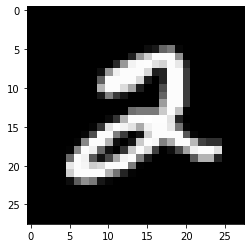

In [7]:
plt.imshow(img,cmap='gray')

Try some different images:

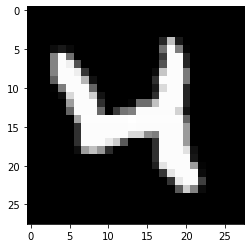

In [8]:
img2 = train[:,20].reshape([28,28])
plt.imshow(img2,cmap='gray')

> Question 1) Now create a 10x10 array of the first 100 images and show it below. It's probably easiest to make a 280 x 280 array, and fill it with the individual images. Be sure to scale your displayed image so that it is big enough to see individual images, i.e., so that it fills most of the browser window. 

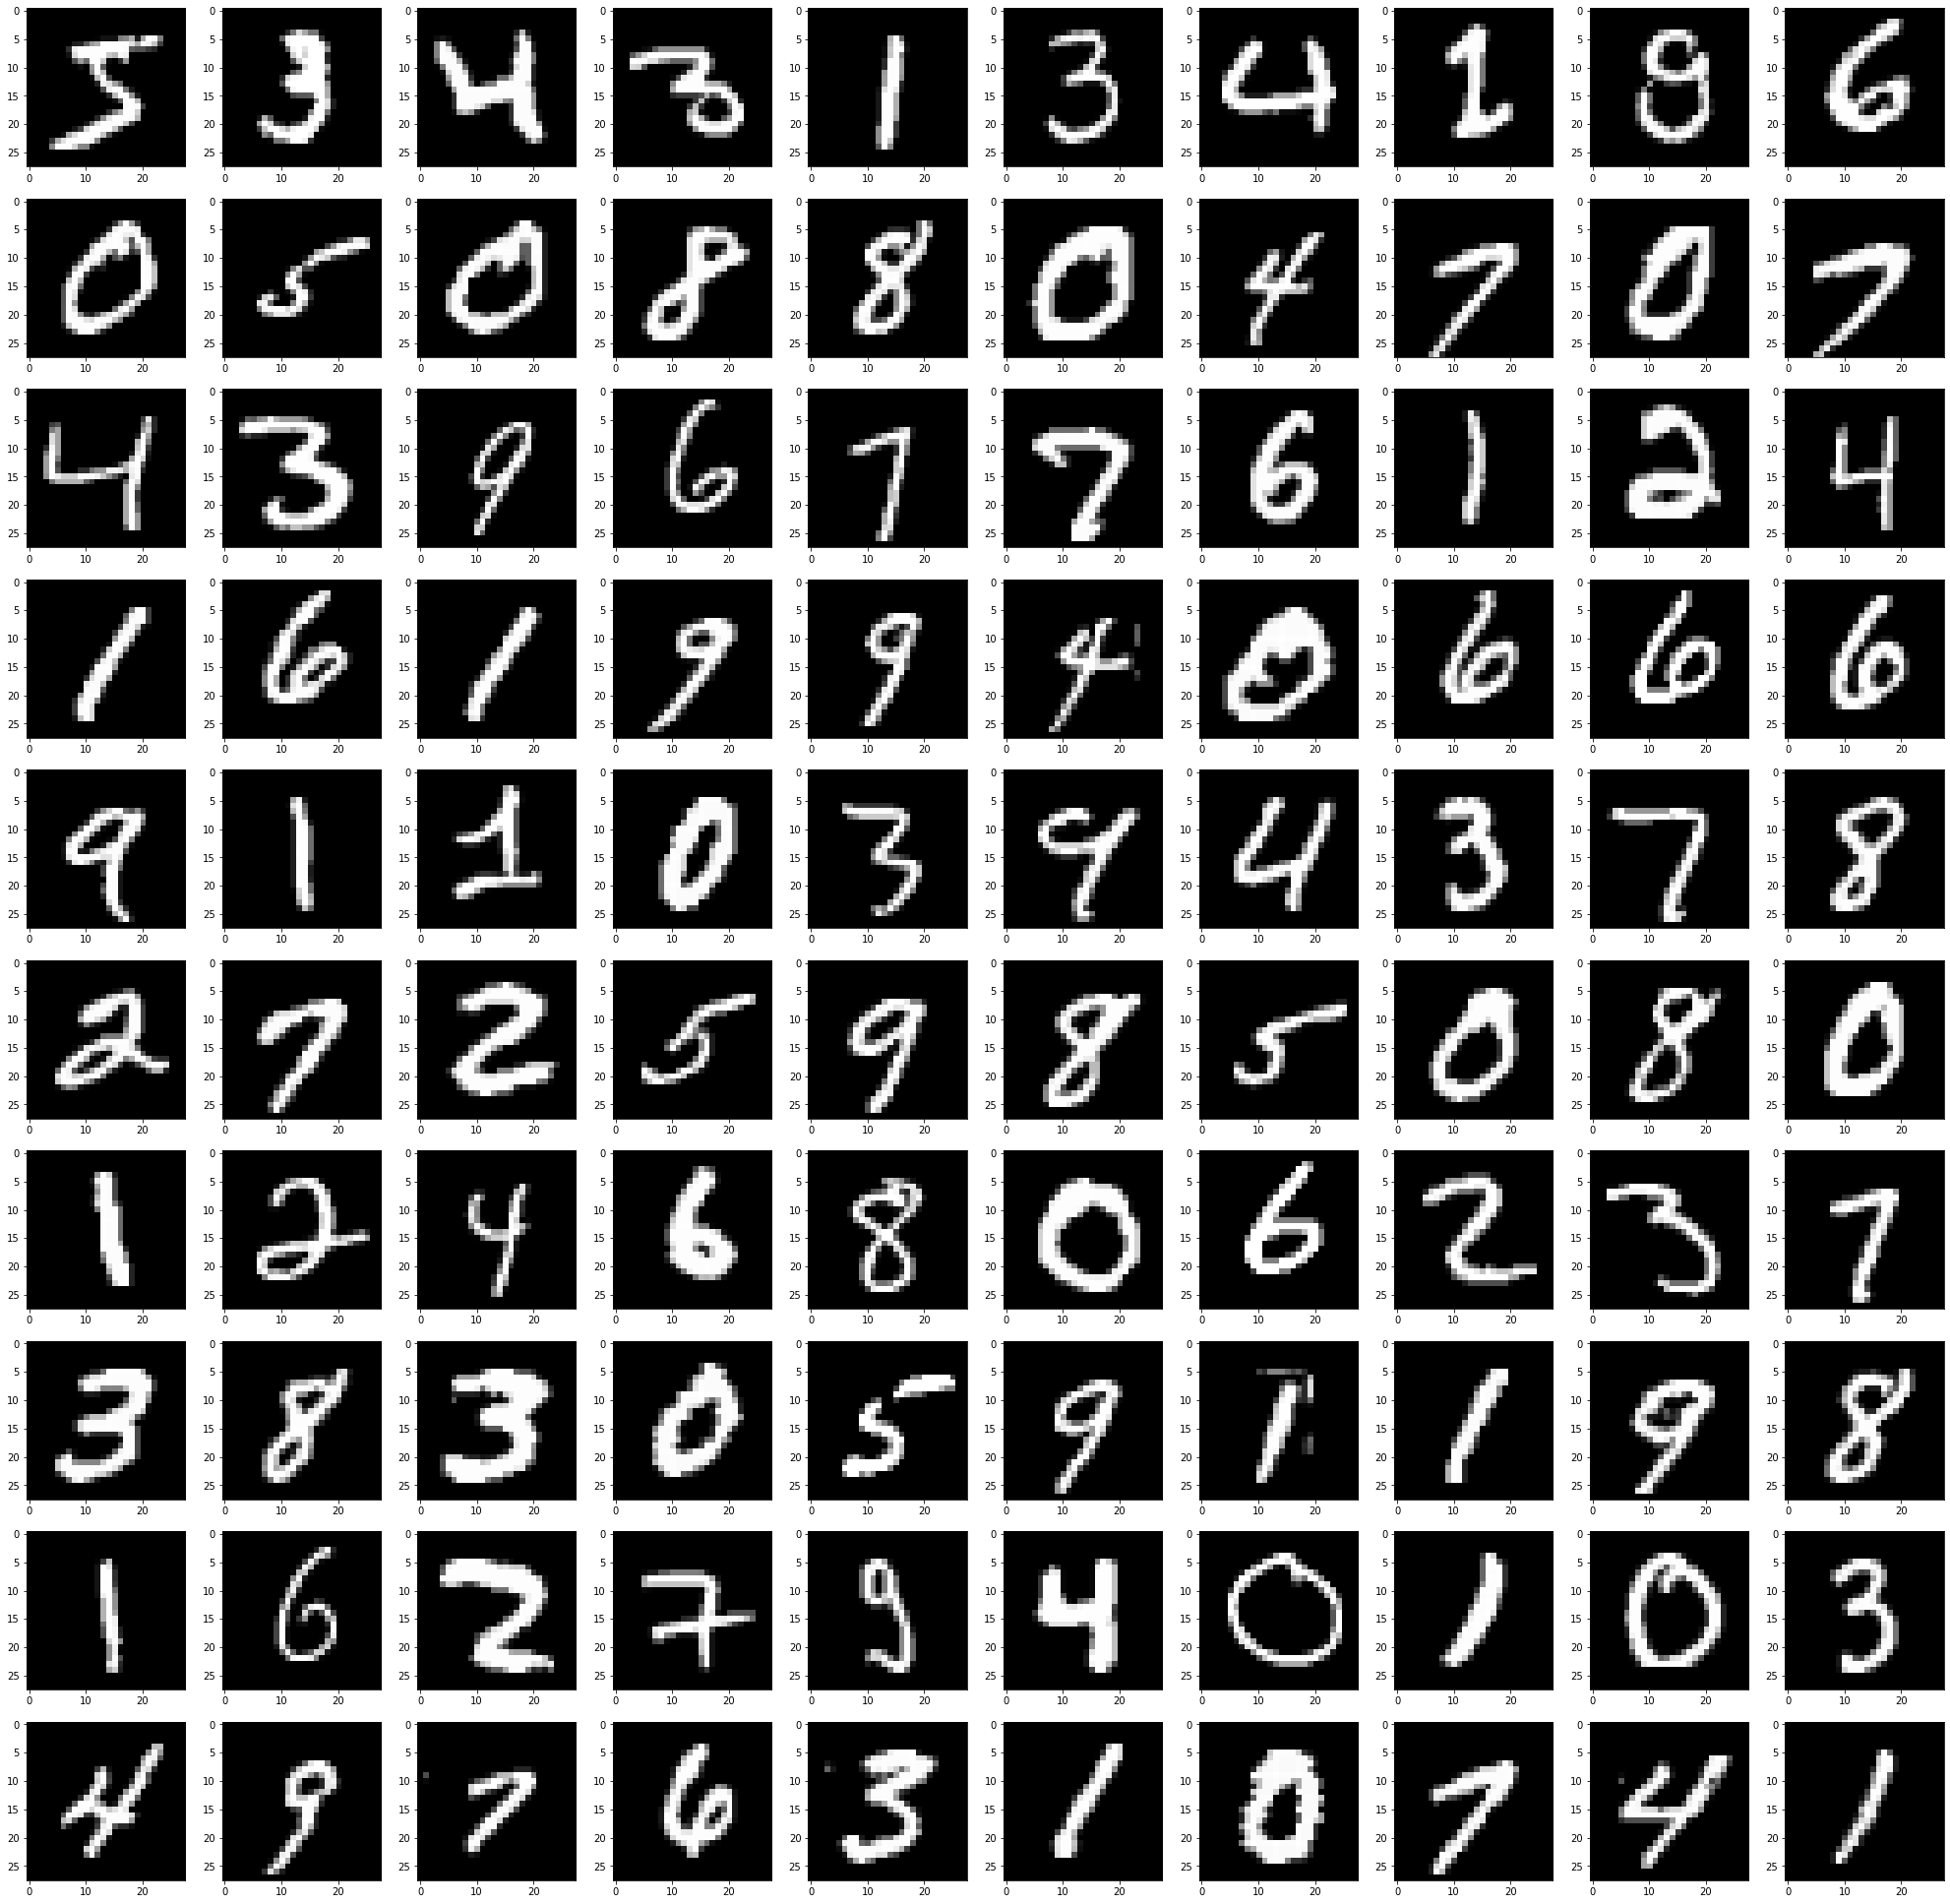

In [9]:
# Add your code here

train_image = train[:,:100]
data = np.array(train_image.T)

fig, plot_img = plt.subplots(10, 10,figsize = (35,35))
ind = list(range(100))


for i in ind:    
    
    image = data[i,:].reshape([28,28]) 
    pos = ind[i]
    x = pos % 10
    y = pos // 10
    plot_img[x,y].imshow(image,cmap='gray')



## Computing Test/Train Set Distances

Next we need to compute the pairwise distances between our test and training set. Check the test set dimensions:

In [10]:
test0=np.loadtxt("test.fmat.txt")
test=test0[:,0:2000]
ntest=test.shape[1];ntest

2000

The squared euclidean distance between two vector x and y is the squared length of their difference. We can write it as
<pre>(x-y) dot (x-y)</pre>
When working with matrices, we can also use a matrix formula, which is
<pre>transpose(x-y) * (x-y)</pre>
We'll use the shorthand ".T" for the transpose, and then we can write:
<pre>(x-y) dot (x-y) = x dot x - 2 x.T * y + y dot y</pre>
This formula works for x and y which are single columns. We chose this combination of dot and transpose product so we can generalize it to matrices of points.

We would like to efficiently compute a ntest x ntrain matrix of all pairwise distances using this formula. The first term should be the x dot products, which we can compute like this:

In [11]:
xdots = np.sum(np.multiply(test,test),0).reshape(ntest,1) * np.ones((1,ntrain))

Note that we had to multiply by a row-vector of ones to reproduce the x-product for each y. The formula for y dot products is similar:

In [12]:
ydots = np.ones((ntest, 1)) * np.sum(np.multiply(train,train),0).reshape(1,ntrain) 

Finally, we can complete the distance formula by adding the cross-terms:

In [13]:
dists = xdots + ydots - 2 * np.transpose(test) * train

The raw distances will be larger for larger input instances, which is not what we want. We can improve the distance estimate by normalizing the lengths of test and train instances:

> Question 2) produce a normalized distance matrix ndists by dividing by the eucliden length of the test and train points. Hint: you already have the squared euclidean lengths of all the test and train points.

In [14]:
normalize = np.multiply(xdots,ydots)
normalize = np.sqrt(normalize)
ndists = np.divide(dists,normalize)

Now the i-th row of the distance matrix is the vector of distances from the i-th test point to the training points. To get the closest neighbors, we can sort this array along its rows (axis = 1). The argsort function returns the index of the closest points, which we can use to lookup their label. 

In [15]:
ibest = np.argsort(ndists,axis=1); ibest

matrix([[1673,  522, 3324, ..., 1131, 3607, 1080],
        [1609, 1874, 2738, ...,  418, 1080, 1031],
        [1697, 2301, 1658, ..., 1367, 2009, 3106],
        ...,
        [1130,   98, 1144, ..., 2732,  294, 3370],
        [3678,  350, 1960, ..., 1102, 3016, 3734],
        [3170, 3870, 1556, ..., 1031,  418, 1080]], dtype=int64)

To look up the distances along a given row, we can use the ibest array to provide the column (training point) indices. 

In [16]:
irow = 0
ndists[irow,ibest[irow,:]]

matrix([[0.29291391, 0.30300264, 0.30331726, ..., 1.92484544, 1.98639867,
         2.0672592 ]])

And then to get their labels we should load the label data matrix:

In [17]:
labels = np.loadtxt("ictrain.imat.txt")

In [18]:
labels[ibest[irow,:]]

array([[7., 7., 7., ..., 1., 2., 1.]])

> Question 3) What label is the best match for test point 0? 

Now we'll restrict ourselves to the k-nearest neighbors. We currently have all the neighbors as columns of the dists and ibest matrices. Let's produce the labels of only the k-nearest, which is simply:

In [19]:
k = 3

In [20]:
knlabels = labels[ibest]; knlabels

array([[7., 7., 7., ..., 1., 2., 1.],
       [2., 2., 2., ..., 8., 1., 1.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [3., 3., 3., ..., 4., 4., 4.],
       [9., 9., 9., ..., 0., 0., 0.],
       [5., 5., 5., ..., 1., 8., 1.]])

to get the k-nearest distances, we can sort the distances directly:

In [21]:
ndists[0,ibest[0,:]]

matrix([[0.29291391, 0.30300264, 0.30331726, ..., 1.92484544, 1.98639867,
         2.0672592 ]])

Now, let's find the majority vote for each label. First we need to count the votes in a matrix whose columns are the possible digits. You'll need to do this with loops, since Python lacks a general accumulate function.

In [22]:
votes = np.zeros((ntest,10))

In [23]:
votes

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

> Question 4) Write code to fill out the votes array with the predicted labels using the k nearest neighbors.

In [24]:
# your code here
for i in range(ndists.shape[0]):
    for j in range(k):
        votes[i,int(knlabels[i][j])] += 1
votes


array([[0., 0., 0., ..., 3., 0., 0.],
       [0., 0., 3., ..., 0., 0., 0.],
       [0., 3., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 3.],
       [0., 0., 0., ..., 0., 0., 0.]])

Then we can find the position of the maximum of the votes, which will also be the digit label:

In [25]:
bestlabels = np.argmax(votes, axis=1); bestlabels

array([7, 2, 1, ..., 3, 9, 5], dtype=int64)

How well did we do? Let's load the test labels and see:

In [26]:
testlabels0 = np.loadtxt("ictest.imat.txt")
testlabels = testlabels0[0:ntest]

We can directly compare the bestlabels (predicted) and the testlabels with == to compute matches. Matching labels will produce a 1 or 0 otherwise. To find the fraction of matches we simply take the mean of the 0-1 values. 

In [27]:
accuracy = np.mean(bestlabels == testlabels); accuracy

0.9125

Now lets try some other values of k. To speed things up, we'll skip the expensive sort steps, which we've already done anyway. 

In [28]:
k = 3
votes = np.zeros((ntest,10))

# Add your code for vote counting here
for i in range(ndists.shape[0]):
    for j in range(k):
        votes[i,int(knlabels[i][j])] += 1

bestlabels = np.argmax(votes, axis=1)

np.mean(bestlabels == testlabels)

0.9125

> Question 5) What was the best value of k <= 10? What is the corresponding accuracy? 

In [29]:
# Add your response here
# The best value was when K=4 with the accuracy of 0.917.

Now let's try weighting by inverse distance. Modify the last compute cell to use the inverse distance (you probably want to use the kndists matrix) as the vote. 

In [30]:
k = 3
inverse = np.array(1/ndists)
votes = np.zeros((ntest,10))
votes = np.zeros((ntest,10))

# Add your code for vote counting here

for i in range(inverse.shape[0]):
    for j in range(k):
        votes[i,int(knlabels[i][j])] += (1*inverse[i][j])

bestlabels = np.argmax(votes, axis=1)

np.mean(bestlabels == testlabels)

0.9145

> Question 6) Now what is the next value of k <= 10? What is the corresponding accuracy? 

In [31]:
# Add your response here

# It is 0.9145 when k = 3.

# Naive Bayes

Read the documentation for Naive Bayes in Scikit-learn here http://scikit-learn.org/stable/modules/naive_bayes.html .
    This section uses Scikit-learn, which is installed through Anaconda (if for some reason it is not already installed, use the Anaconda GUI or Prompt to install `scikit-learn`).

We want to classify our image data, and so we have to choose a feature distribution. Although the data for MNIST are real 0..255 brightness values, most values are either 0's or 255's so we'll threshold them to produce binary features. Then we can use the Bernoulli Naive Bayes classifier. 

We also need to transpose the data: Sckikit-learn expects data points to be rows rather than columns.

In [32]:
btrain = np.transpose(train > 128)
btest = np.transpose(test > 128)

Now import the BernoulliNB classifier:

In [33]:
from sklearn.naive_bayes import BernoulliNB
nb = BernoulliNB()

Which creates a new Bernoulli Naive Bayes classifier. Now train the classifier on your binarized training data. 

In [34]:
model = nb.fit(btrain, labels)

C:\Users\neoar\.julia\conda\3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


Use the model to predict the labels of the binarized test data:

In [35]:
nbpreds = model.predict(btest)

And evaluate the predictions compared to the actual labels

In [36]:
np.mean(nbpreds == testlabels)

0.7805

> Question 7) How did the accuracy of Naive Bayes compare with the kNN classifier on this data? 

In [37]:
# Add your response here

# With the accuracy of 0.917, KNN classifier performed better than Naive Bayes
# which had the accuracy of 0.7805.

> Question 8) How well do you think this dataset fits the assumptions of the kNN and Naive Bayes models respectively?

In [38]:
# Add your response here
# Naive Bayes model tends to perform better if we have the dataset in binary form.
#That is why it perfromed worse than the KNN.
# KNN does well when we have feature and values like in the dataset we have.

# Diagnosing Performance: Confusion Matrices

Let's dig a bit deeper into the results from both classifiers. One useful tool is a confusion matrix: this is a matrix index by the true labels and predicted labels, and holds the normalized counts of values in each element. We can form the matrix as follows.

We start with a matrix C such that C[i,j] is a count of the points with predicted label i and true label j. We then normalize C so that its columns add up to 1. Then the j^th column corresponds to true label j, and is a vector of the probabilities that a true label of j is classified as one of the other labels. 

In [39]:
def confCount(a0, b0):
    a = a0.astype('int64')
    b = b0.astype('int64')
    counts = np.zeros((10,10))
    for i in range(0,a.size):
        counts[b[i],a[i]] += 1
    return counts           
            

In the cell below, we compute the confusion matrix for the Naive Bayes classifier. 

In [40]:
ccounts = confCount(testlabels, nbpreds)
conf = ccounts / sum(ccounts).reshape(10,1)
conf

array([[0.85714286, 0.        , 0.01142857, 0.        , 0.00571429,
        0.02857143, 0.02857143, 0.        , 0.00571429, 0.00571429],
       [0.        , 0.95726496, 0.03418803, 0.01709402, 0.00854701,
        0.00854701, 0.01282051, 0.05555556, 0.01709402, 0.0042735 ],
       [0.00456621, 0.        , 0.75342466, 0.00456621, 0.        ,
        0.00913242, 0.0456621 , 0.02283105, 0.02283105, 0.        ],
       [0.        , 0.        , 0.04830918, 0.79227053, 0.        ,
        0.11594203, 0.        , 0.        , 0.09661836, 0.01932367],
       [0.        , 0.        , 0.00460829, 0.00460829, 0.75576037,
        0.02764977, 0.04608295, 0.03225806, 0.02764977, 0.09677419],
       [0.05027933, 0.03351955, 0.00558659, 0.07821229, 0.00558659,
        0.67597765, 0.03910615, 0.00558659, 0.0726257 , 0.01117318],
       [0.03932584, 0.01123596, 0.04494382, 0.02247191, 0.03370787,
        0.01685393, 0.78651685, 0.        , 0.01123596, 0.        ],
       [0.        , 0.        , 0.0243902

> Question 9) Now in the cell below create a grayscale visualization of the confusion matrix. i.e. a 10 x 10 image whose elements are in the range 0..255 and are 255 times the values of the confusion matrix. 

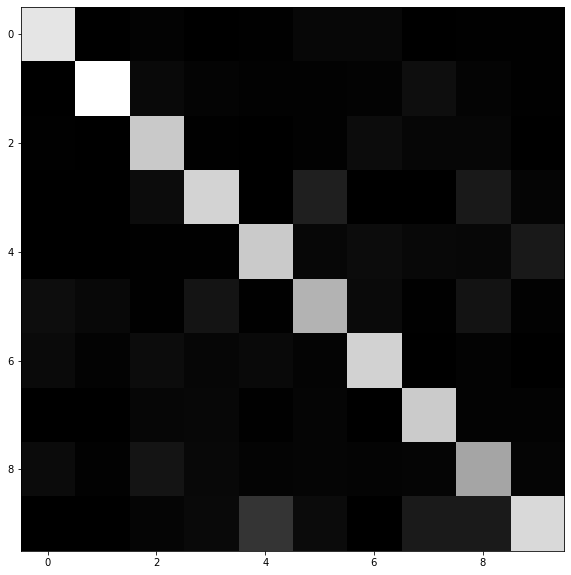

In [41]:
# Add your code here
plt.figure(figsize=(10,10))
plt.imshow(conf*255,cmap='gray')

Using the vizualization or the matrix itself, answer these questions:

> Question 10) Which digit is misclassified most often? How did you derive your answer from the confusion matrix?

> Question 11) How many mislabeled pairs are there (a pair of correct digits, incorrectly label) which have probability > 0.05 ? 

In [42]:
# Add your Question 10 response here
# After looking at the confused matrix, the digit that is misclassified most 
# often is 9. Number 9 is in the farthest corner and also is in the bottom one.


In [43]:
# Add your Question 11 response here
# There are 2 of them according to the confused matrix above.

Done! Save and submit your notebook on Canvas!